# STEP 1: From GermanBERT to LernnaviBERT

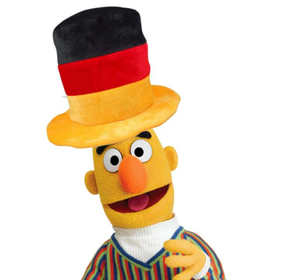

[Source of the image: https://huggingface.co/bert-base-german-cased]

In order to transform a pretrained GermanBERT model in a model able to predict the students’ answers to Multiple Choice Questions (MCQs), we decided to follow a pipeline made of three steps:
1. Finetuning GermanBERT on language modelling considering the Lernnavi dataset. The finetuned model will be renamed "LernnaviBERT" for clarity;
2. Finetuning LernnaviBERT to predict the correct answers to MCQs;
3. Further finetuning the model on the final downstream task, that is the prediction of the answers of a given student to MCQs, taking into account the embedding of the student.

In this notebook, we will perform the first step, that is the finetuning of a standard GermanBERT model on the Lernnavi dataset containing MCQs. To do so, we will follow an approach which is similar to the one which has been used to train the original BERT model. This notebook has been adapted from the HuggingFace tutorial ["Fine-tuning a masked language model"](https://huggingface.co/learn/nlp-course/chapter7/3?fw=tf).

## Theoretical motivation

The language models of the BERT family are usually extensively pretrained on a huge and varied corpus, and can therefore be effectively finetuned on a variety of downstram task without the need of further finetuning them on language modelling tasks. This approach, which is possible thanks to transfer learning, is likely to produce good results as long as the corpus used for pretraining the BERT model is not too different from the corpus used for finetuning on the downstream task (in our case, MCQs prediction). This is due to the fact that if the dataset used for finetuning on the downstream task is containing domain-specific words which were not observed while training, the model would treat these words as rare tokens, causing a rapid decrease in the resulting performance. As stated previously, we decided to consider GermanBERT as our BERT model ("dbmdz/bert-base-german-uncased" on HuggingFace Hub), which according to the model card (https://huggingface.co/dbmdz/bert-base-german-uncased) has been trained on a dataset of 16GB (2,350,234,427 tokens) that includes various sources: a Wikipedia dump, EU Bookshop corpus, Open Subtitles, CommonCrawl, ParaCrawl and News Crawl. Although the dataset used for training seems extensive, and our dataset based on Lernnavi MCQs do not seem too domain-specific, we decided to finetune GermanBERT on our dataset (domain adaptation) in order to verify whether this leads to a performance boost. An advantage of this approach is that the obtained model, LernnaviBERT, could be used on a variety of downstream tasks on the Lernnavi dataset, and the finetuned model by itself could be valuable to the scientific community in the future.

The scheme below depicts the first finetuning step that we will perform in this notebook:

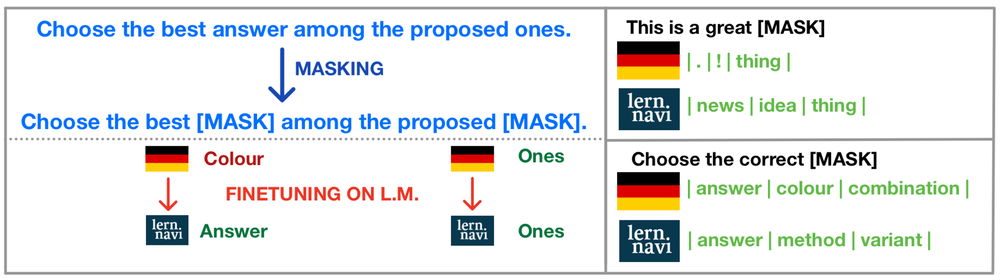

## STEP 1

The first aspect we will address is preprocessing the Lernnavi dataset containing MCQs to be suitable for our task. In particular, since we are interested to let the model adapt to the language used in the MCQs, we are not directly interested about preserving the entity of each question. For this reason, we will concatenate all the samples and split the corpus in chunks with equal size (which should be smaller than the maximum context size of the model).

Then, we import all the packages which are necessary to run the notebook.

In [1]:
from huggingface_hub import notebook_login
from transformers import AutoModelForMaskedLM, AutoTokenizer, DataCollatorForLanguageModeling, Trainer, TrainingArguments, pipeline, default_data_collator
import torch
import pickle
from bs4 import BeautifulSoup
from datasets import Dataset
import collections
import numpy as np
import math

Since we want to push the finetuned model (LernnaviBERT) to HuggingFace Hub, we have to login to the Hub using HuggingFace token. It should be noted that this cell requires to be run alone (i.e. the cells should not be run all together up to here), otherwise it would be impossible to insert the token and to login successfully.

In [2]:
notebook_login()

At this point, we define the model we want to use as our starting point, and we load both the model and the tokenizer from the checkpoint. As stated above, we decided to use the GermanBERT model provided by DBMDZ, available on HuggingFace Hub and called "dbmdz/bert-base-german-uncased".

In [3]:
BASE_DATA_DIR = "../../data"
QNA_DATA_DIR = f"{BASE_DATA_DIR}/lernnavi/qna"
ORIGINAL_DATA_DIR = f"{BASE_DATA_DIR}/original/data"

In [4]:
model_checkpoint = "dbmdz/bert-base-german-uncased"

model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-german-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/247k [00:00<?, ?B/s]

Just to verify how the model works, we can introduce a sample of text with a mask token ([MASK]) and verify which tokens the model predicts as the most likely completions (we will consider five completions). Since GermanBERT expects a German text, we will use as sample text the translation in German of the sentence "This is a good [MASK]".

In [5]:
text = "Das ist eine gute [MASK]."

To determine the most probable five completions, we pass the text to the model, extract the logit, and print the five candidates.

In [6]:
inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for count, token in enumerate(top_5_tokens):
    print("---- Completion ", count + 1, " ----")
    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

---- Completion  1  ----
'>>> Das ist eine gute idee.'
---- Completion  2  ----
'>>> Das ist eine gute sache.'
---- Completion  3  ----
'>>> Das ist eine gute frage.'
---- Completion  4  ----
'>>> Das ist eine gute entscheidung.'
---- Completion  5  ----
'>>> Das ist eine gute nachricht.'


The most probable five completions are the following (the translation has been added for clarity):
1. Das ist eine gute idee. -> This is a good IDEA.
2. Das ist eine gute sache. -> This is a good THING.
3. Das ist eine gute frage. -> This is a good QUESTION.
4. Das ist eine gute entscheidung. -> This is a good DECISION.
5. Das ist eine gute nachricht. -> This is a good NEWS.

At this point, we load the dataset that we will use in order to finetune the model on the language modelling task. In particular, we will consider a dataset we processed previously containing MCQs from Lernnavi. This dataset, among the others, contains the field "question" (indicating the text of each MCQ) and the field "choices" (indicating the possible choices among a user can choose from). After loading the dataset, we only keep the two columns described, and we use 'BeautifulSoup' to remove the HTML tags.

In [8]:
# Step 1: Load the dataset
with open(f'{QNA_DATA_DIR}/MULTIPLE_CHOICE_german.pkl', 'rb') as file:
    data = pickle.load(file)

# Step 2: Select which columns to keep
data = data[["question", "choices"]].reset_index(drop = True)

# Step 3: Remove HTML tags
data["question"] = data["question"].apply(lambda x: BeautifulSoup(x, "html.parser").get_text())
data["choices"] = data["choices"].apply(lambda x: [BeautifulSoup(a, "html.parser").get_text() for a in x])

# Step 4: Convert the dataset to the required format
data = Dataset.from_pandas(data)

/tmp/ipykernel_987/3443308654.py:10: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  data["choices"] = data["choices"].apply(lambda x: [BeautifulSoup(a, "html.parser").get_text() for a in x])


We now tokenize our dataset, without truncating the individual samples (since we will split them later). It should be noted that we concatenate both the question and the choices as a preprocessing step, in order to tokenize the whole text of each MCQ. The tokenized dataset is saved in the variable 'tokenized_datasets'.

In [9]:
def tokenize_function(examples):
    to_tokenize = examples["question"]
    for answer in examples["choices"]:
        to_tokenize += answer
    result = tokenizer(to_tokenize)
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

tokenized_datasets = data.map(
    tokenize_function, batched=True, remove_columns=["question", "choices"]
)

Parameter 'function'=<function tokenize_function at 0x7fdc861a74c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/139 [00:00<?, ?ba/s]

At this point, we have to group all the samples and split them into chunks. In order to determine the length of each chunk, we have to take into account the maximum context size of the model (512) and the amount of GPU memory available. It should also be taken into account that a small chunk size may not be the best choice, as the context would not be taken into account during the fine-tuning. Since we will run this notebook on Colab, and the amount of GPU memory should not be an issue, we set the chunk size to 256, which is half the maximum context size of the model.

In [10]:
chunk_size = 256

To show how the concatenation works, we can consider the first twenty tokenized samples (MCQs) and verify the number of tokens they contain.

In [11]:
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_datasets[:20]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> MCQ {idx} length: {len(sample)}'")

'>>> MCQ 0 length: 28'
'>>> MCQ 1 length: 28'
'>>> MCQ 2 length: 28'
'>>> MCQ 3 length: 28'
'>>> MCQ 4 length: 28'
'>>> MCQ 5 length: 28'
'>>> MCQ 6 length: 28'
'>>> MCQ 7 length: 28'
'>>> MCQ 8 length: 28'
'>>> MCQ 9 length: 28'
'>>> MCQ 10 length: 28'
'>>> MCQ 11 length: 28'
'>>> MCQ 12 length: 28'
'>>> MCQ 13 length: 28'
'>>> MCQ 14 length: 28'
'>>> MCQ 15 length: 28'
'>>> MCQ 16 length: 28'
'>>> MCQ 17 length: 28'
'>>> MCQ 18 length: 28'
'>>> MCQ 19 length: 28'


We then concatenate the samples by using a dictionary comprehension and we verify the total length in tokens.

In [12]:
concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'>>> Concatenated MCQs length: {total_length}'")

'>>> Concatenated MCQs length: 560'


At this point, we split the MCQs into chunks whose size is 256 (according to what has been indicated in the variable 'chunk_size'). We can then verify the length of each individual chunk.

In [13]:
chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()
}

for chunk in chunks["input_ids"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

'>>> Chunk length: 256'
'>>> Chunk length: 256'
'>>> Chunk length: 48'


At this point, we define a function to create chunks of length 256 starting from the complete MCQs dataset. As we noticed above, the last chunk may be smaller than 256, and the approach chosen here is to simply discard it.

In [14]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

An important aspect about the function 'group_texts()' is that it creates a new column called "labels" which, for the moment, is a copy of the "input_ids" one. This is due to the fact that we are interested in masking some tokens to let the model predict them, and we will therefore need the ground truth while training.

At this point, we create a new dataset containing the chunks as samples.

In [15]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)

  0%|          | 0/680 [00:00<?, ?ba/s]

We are still missing an important step at this point, that is masking some of the tokens in each chunk in order to finetune the model on a language modelling task. In order to do this, we consider a data collator which is suited for this task, 'DataCollatorForLanguageModeling'. We will pass to this data collator the tokenizer and an argument indicating what fraction of the tokens to mask. Following a common choice in the literature, we will mask 15% of the token (which is also the amount used to train BERT).

In [16]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

We can verify how the random masking works by feeding some chunks to the data collator. 

In [17]:
samples = [lm_datasets[i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")


'>>> [CLS] markiere die satze mit der korrekte [MASK] komm [MASK]tzung als " [MASK] " und die ubrigen als " falsch " 1813 [SEP] [CLS] [MASK]iere die satz [MASK] mit der korrekten kommasetzung als [MASK] richtig " [MASK] die ubrigen [MASK] " falsch ". [SEP] [CLS] markiere die satze mit der korrekten kommasetzung [MASK] " richtig " und die ubrigen als [MASK] falsch ". [SEP] [CLS] markiere die satze mit der korrekten kommasetzung als [MASK] richtig " und die ubrigen als " falsch ". [SEP] [CLS] markiere die satz [MASK] mit der korrekten kommasetzung als " richtig " und die ubrigen als " falsch ". [SEP] [CLS] markiere die satze mit der korrekten kommasetzung als " richtig " und die ubrigen als [MASK] falsch [MASK]. [SEP] [CLS] [MASK]iere die satze [MASK] der korrekten kommasetzung als " richtig " und die ubrigen [MASK] " falsch ". [SEP] [CLS] [MASK]iere die satze mit der korrekten [MASK]asetzung als:58 [MASK] " und die ubrigen als " falsch ". [SEP] [CLS] markiere die satze mit der korrekte

From the examples, we can verify that the '[MASK]' token has been randomly inserted at various locations in the MCQs. These will be the tokens that the model will have to predict while training.

While masking individual tokens is effective to finetune a model on a language modelling task, an alternative approach could be to mask whole words instead of tokens (whole word masking). While we will consider the first approach (i.e. masking tokens), we introduce here a custom data collator that would allow to finetune the model by masking whole words instead of tokens.

In [18]:
wwm_probability = 0.2

def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels

    return default_data_collator(features)

From now on, the procedure considered is standard. We start by defining the train size and the test size, and we split the dataset in a training dataset and a test dataset.

In [19]:
train_size = int(len(lm_datasets) * 0.8)
print(f"'>>> Train size: {train_size}'")
test_size = len(lm_datasets) - train_size
print(f"'>>> Test size: {test_size}'")

train_test_dataset = lm_datasets.train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)

'>>> Train size: 38477'
'>>> Test size: 9620'


We then specify the training arguments. It should be noticed that we indicate at this point that we would like to push the finetuned model to HuggingFace Hub, and the name of the model to be saved.

In [22]:
from pathlib import Path

batch_size = 16
# Show the training loss with every epoch
logging_steps = len(train_test_dataset["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

Path(f"{BASE_DATA_DIR}/../checkpoints/LernnaviBERT").mkdir(parents=True, exist_ok=True)

training_args = TrainingArguments(
    output_dir=f"{BASE_DATA_DIR}../checkpoints/LernnaviBERT",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
)

The next step is to define the trainer.

In [23]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_test_dataset["train"],
    eval_dataset=train_test_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

Since we are interested in quantitatively evaluating the model before and after the finetuning, we compute the perplexity of the pretrained model. In this context, a low perplexity indicates that the model is not "surprised" or "perplexed" by the unseen examples (and, as a consequence, that it has learned the basic patterns of grammar on the corpus considered). In this case, we define the perplexity as the exponential of the cross-entropy loss.

In [24]:
eval_results = trainer.evaluate()
print(f">>> Perplexity (before fine-tuning): {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity (before fine-tuning): 1.21


We are finally ready to start the training, in order to finetune our model.

In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.038500,0.013740
2,0.014200,0.008401
3,0.009600,0.007238


TrainOutput(global_step=7215, training_loss=0.02076574890246345, metrics={'train_runtime': 1845.558, 'train_samples_per_second': 62.545, 'train_steps_per_second': 3.909, 'total_flos': 1.519110020832768e+16, 'train_loss': 0.02076574890246345, 'epoch': 3.0})

After training, we can recompute the perplexity to verify whether it is smaller than the one obtained previously.

In [26]:
eval_results = trainer.evaluate()
print(f">>> Perplexity (after fine-tuning): {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity (after fine-tuning): 1.01


The perplexity is indeed smaller, indicating that the model has learnt the basic patterns of the corpus we considered. This is a useful indication that the finetuning process may have been successful.

At this point, we can push the model to the HuggingFace Hub, so that we will be able to retrieve it while performing the next steps of our pipeline.

In [27]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/tommymarto/LernnaviBERT/commit/f47e05d2f6633eabfdb5c340f099eded06254da1', commit_message='End of training', commit_description='', oid='f47e05d2f6633eabfdb5c340f099eded06254da1', pr_url=None, pr_revision=None, pr_num=None)

At this point, we demonstrate how the model which has been just saved to HuggingFace hub can be retrieved, and can be used to predict the most probable completion of the text we considered at the beginning of the notebook.

In [28]:
mask_filler = pipeline(
    "fill-mask", model="tommymarto/LernnaviBERT"
)

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.26k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/247k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/737k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

We determine the most probable completions.

In [29]:
preds = mask_filler(text)

for count, pred in enumerate(preds):
    print("---- Completion ", count + 1, " ----")
    print(f">>> {pred['sequence']}")

---- Completion  1  ----
>>> das ist eine gute sache.
---- Completion  2  ----
>>> das ist eine gute nachricht.
---- Completion  3  ----
>>> das ist eine gute idee.
---- Completion  4  ----
>>> das ist eine gute wahl.
---- Completion  5  ----
>>> das ist eine gute arbeit.


The most probable five completions are the following (the translation has been added for clarity, the suggestion obtained before finetuning is between parentheses):

1. das ist eine gute sache. -> this is a good THING. (This is a good IDEA.)
2. das ist eine gute nachricht. -> this is a good NEWS. (This is a good THING.)
3. das ist eine gute idee. -> this is a good IDEA. (This is a good QUESTION.)
4. das ist eine gute wahl. -> this is a good CHOICE. (This is a good DECISION.)
5. das ist eine gute arbeit. -> this is a good WORK. (This is a good NEWS.)

From the proposed completions, it seems clear that the model did not completely shift the predictions with respect to before (which is a positive aspect, as we don't want the model to forget the training performed up to this point). Nevertheless, the predictions are more tied to education and learning (in particular the introduction of the word 'CHOICE').

Since the first step seems to give good results, both qualitatively (visual inspection of the completions) and quantitatively (reduction of perplexity), we now proceed to the second step, that is finetuning LernnaviBERT on the prediction of the correct answers to MCQs.

**NOTE**: The complete analysis of these results is presented in the report describing the final milestone of the project.